# Convolutional Neural Networks

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml

In [11]:
images, labels = fetch_openml('mnist_784', version=1, return_X_y=True)

In [12]:
df = images.copy()
df['class'] = labels.copy().astype(np.int32)
df.head(5)

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784,class
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9


In [13]:
df.loc[:, df.columns != "class"] /= 255.0
df.head(5)

/tmp/ipykernel_5249/351404995.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0. 0. 0. ... 0. 0. 0.]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[:, df.columns != "class"] /= 255.0
/tmp/ipykernel_5249/351404995.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0. 0. 0. ... 0. 0. 0.]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[:, df.columns != "class"] /= 255.0
/tmp/ipykernel_5249/351404995.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0. 0. 0. ... 0. 0. 0.]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[:, df.columns != "class"] /= 255.0
/tmp/ipykernel_5249/351404995.py:1: FutureWarning: Setting an item of 

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784,class
0,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0,0,0,0,5
1,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0,0,0,0,4
3,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0,0,0,0,9


In [14]:
print(df["class"].value_counts())

class
1    7877
7    7293
3    7141
2    6990
9    6958
0    6903
6    6876
8    6825
4    6824
5    6313
Name: count, dtype: int64


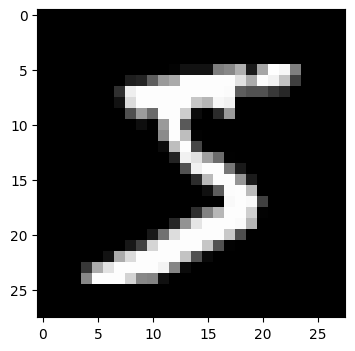

In [15]:
plt.figure(figsize=(4, 4))
plt.imshow(df.iloc[0, :-1].to_numpy().reshape(28, 28), cmap='gray')

In [24]:
from sklearn.model_selection import train_test_split

# Stratify ensures the proportion of classes in the test train split is similar to that in the class column.
# The distribution of our test set classes are that of our training set.
train_df, test_df = train_test_split(df, test_size=0.1, stratify=df['class'])

### CNN working

CNNs are better at handling long sequences, if we were to pass a (256x256) image through a linear layer to an output (256x256), it would require learning $256^{4}$ parameters. Furthermore, linear layers completely ignore the structure of the data, re-ordering the input features will mean the weights are learned reordered and results are similar. For example, a kernel could be an edge detector.

CNNs apply convolutions over sequential data, learning local patterns and motifs in the data, it is a feature extractor. They do this by applying a convolutional filter/kernel over the data. The kernel has the following parameters:

- Kernel size: For sequences (subsequence length, ), images (width, height)
- Stride: By how much a kernel moves across the data.
- Dilation: How spread out the kernel is, does its consider adjacant data, data 2 apart, etc.

Applying kernels over an image dataset will give the following output size: $(num\_kernels, image\_width - kernel\_width, image\_height - kernel\_height) / stride$ + 1.

As we compose convolutional layers, our output features consider more and more of the total image, the amount of the total image considered is known as the receptive field.

In CNNs, the input should be of shape (batch\_size, width, height, channels) where channels is the number of features per width and height. The pooling is applied over the block of kernel applications.

In [17]:
import jax
import optax
import jax.numpy as jnp
import flax.linen as nn
from jax.nn.initializers import lecun_normal

In [138]:
class CNN(nn.Module):

    @nn.compact
    def __call__(self, x):
        batch_size = x.shape[0]
        # Feature Extraction (Encoder)
        x = nn.Conv(features=64, kernel_size=(3, 3), padding = "SAME", kernel_init = lecun_normal())(x)
        x = nn.relu(x)
        x = nn.max_pool(x, window_shape=(2, 2), strides=(2, 2))

        x = nn.Conv(features=64, kernel_size=(3, 3), padding = "SAME", kernel_init = lecun_normal())(x)
        x = nn.relu(x)
        print(x.shape)
        x = nn.max_pool(x, window_shape=(2, 2), strides=(2, 2))

        x = x.reshape((batch_size, -1))
        # Decoder
        x = nn.Dense(features = 128)(x)
        x = nn.relu(x)

        x = nn.Dense(features = 10)(x)
        x = nn.softmax(x)

        return x

In [106]:
def get_batch(df, batch_size = 256):
    weights = 1 / df['class'].value_counts()
    sample_weights = df['class'].map(weights)
    batch_sample = df.sample(batch_size, replace=False, weights=sample_weights)
    batch_inputs = batch_sample.drop(['class'], axis=1)
    batch_outputs = batch_sample['class']
    return batch_inputs.values.reshape(-1, 28, 28, 1), batch_outputs.values

In [139]:
rng, init_rng = jax.random.split(jax.random.PRNGKey(42), 2)
model = CNN()

batch_in, batch_out = get_batch(train_df)
params = model.init(init_rng, batch_in)

optimiser = optax.adam(learning_rate=10e-3)
optimiser_state = optimiser.init(params)

(256, 14, 14, 32)


In [108]:
def cross_entropy(params, batch_in, batch_out):
    model_outputs = model.apply(params, batch_in)
    return -jnp.mean(nn.one_hot(batch_out, num_classes=10) * jnp.log(model_outputs))

In [112]:
num_epochs = 1
batch_size = 1024

for epoch in range(num_epochs):
    batch_losses = []
    for batch in range((train_df.shape[0]) // batch_size):
        batch_inputs, batch_outputs = get_batch(train_df, batch_size=batch_size)
        loss, grads = jax.value_and_grad(cross_entropy)(params, batch_inputs, batch_outputs)
        updates, optimiser_state = optimiser.update(grads, optimiser_state)
        params = optax.apply_updates(params, updates)
        batch_losses.append(loss)
    print(f"Average epoch {epoch + 1} loss: {jnp.array(batch_losses).mean()}")

Average epoch 1 loss: 0.040068741887807846


In [135]:
def confusion_matrix(params, batch_in, batch_out):
    confusion_matrix = np.zeros((10, 10))
    predictions = model.apply(params, batch_in)
    predicted_classes = jnp.argmax(predictions, axis=1)
    for (pred, actual) in zip(predicted_classes, batch_out):
        confusion_matrix[pred, actual] += 1
    # Micro-weights are the amount of each class (sum of column counts) / total
    micro_weights = jnp.sum(confusion_matrix, axis=0) / len(batch_out)

    # Precision is diag/row sum
    precisions = jnp.diag(confusion_matrix) / jnp.sum(confusion_matrix, axis = 1)

    # Recall is diag/col_sum
    recalls = jnp.diag(confusion_matrix) / jnp.sum(confusion_matrix, axis = 0)

    print(f"Marco-precision: {jnp.mean(precisions)}")
    print(f"Marco-recall: {jnp.mean(recalls)}")
    print(f"Marco-precision: {jnp.mean(precisions * micro_weights)}")
    print(f"Marco-recall: {jnp.mean(recalls * micro_weights)}")
    print(f"Accuracy: {jnp.sum(jnp.diag(confusion_matrix))/ jnp.sum(confusion_matrix)}")

x, y = get_batch(test_df, batch_size=1024)
confusion_matrix(params, x, y)

Marco-precision: 0.9766311645507812
Marco-recall: 0.9769916534423828
Marco-precision: 0.09768395870923996
Marco-recall: 0.09765625
Accuracy: 0.9765625
